In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get oldest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
2869,2664,16715,8.21.,성동구,-,기타 확진자 접촉,퇴원
2931,2602,16382,8.20.,성북구,-,타시도 확진자 접촉,퇴원
1348,4185,20795,9.02.,강동구,-,기타 확진자 접촉,퇴원
2948,2585,16438,8.20.,성북구,-,확인 중,퇴원
1484,4049,20428,9.01.,도봉구,-,노원구 기도모임,퇴원
1866,3667,19630,8.29.,강서구,-,8.15서울도심집회,퇴원
4314,1219,12419,6.20.,영등포구,-,시청역 관련,퇴원
4019,1514,13874,7.21.,송파구,-,송파구 교회관련,퇴원
2549,2984,17529,8.23.,성북구,-,성북구 체대입시 관련,퇴원
5513,20,121,2.20.,성동구,-,성동구 아파트 관련,퇴원


In [10]:
# overwrite whatever cell value that contains "확인" as "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"] = "확인 중"

df_temp.loc[df_temp["접촉력"].str.contains("조사 중"),"접촉력"] = "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("조사중"),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array(['확인 중'], dtype=object)

In [11]:
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [12]:
infection_paths = df_temp["접촉력"].unique()
print(len(infection_paths))
infection_paths

270


array(['기타 확진자 접촉', '해외 접촉 추정', '도봉구 다나병원', '타시도 확진자 접촉', '확인 중',
       '도봉구 예마루데이케어센터', '영등포구 방문판매업체', '관악구 사랑나무 어린이집', '관악구 큰믿음유신감리교회',
       '동대문구 성경모임', '강북구 북서울 꿈의교회', '강남구 소재 대우디오빌플러스', '서초구 병원',
       '영등포구 LG트윈타워', '서초구 소재 카페', '관악구 지인모임', '동작구 부동산 회사', '관악구 휘트니스',
       '동작구 가족', '마포구 서울디자인 고등학교', '강남구 삼성화재', '양천구 양천경찰서', '서초구 LG 유플러스',
       '고양시부부', '관악구 가족', '관악구 식당', '고양시부부(마포구어린이집&서초구우체국)',
       '관악구가족 (가가호호데이케어센터)', '관악구 삼모스포렉스', '신도림 역사', '강남구 디와이디벨로먼트',
       '송파구 우리교회', '중랑구 서울의료원', '종로구 서울대병원', '성동구 덕수고 야구부', '프로그래머 지인모임',
       '강남구 신도벤처타워', '강남구 K보건산업', '건축설명회', '종로구청', '강남구 통신판매업',
       '도봉구 소재 아파트', '영등포 소재 증권회사', '서대문구 세브란스병원', '영등포구 소재 마트',
       '강남구 소재 금융회사', '동작구 요양시설', '9월 송파구 지인모임', '은평구 수색성당', '서울지방국세청',
       '수도권 지인모임', '서대문구 지인모임', '영등포 지인모임', '관악구 에바다', '광진구 혜민병원',
       '8.15서울도심집회', '도봉구 건설현장', '도봉구 운동시설', '송파구 쿠팡', '노원구 빛가온교회',
       '서초구 장애인교육시설', '강동구 BF모바일', '영등포구 일련정종 서울포교소', '동작구 진흥글로벌',
       '구로구 아파트', 'KT가좌지사', '성북구 사랑제일교회',

In [13]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5533,24567,10.10.,용산구,-,기타 확진자 접촉,NaN
1,5532,24590,10.10.,강동구,브라질,해외 접촉 추정,NaN
2,5531,24589,10.10.,송파구,NaN,기타 확진자 접촉,NaN
3,5530,24588,10.10.,송파구,NaN,기타 확진자 접촉,NaN
4,5529,24587,10.10.,노원구,NaN,도봉구 다나병원,NaN


In [14]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5533,24567,10-10,용산구,-,기타 확진자 접촉,NaN
1,5532,24590,10-10,강동구,브라질,해외 접촉 추정,NaN
2,5531,24589,10-10,송파구,NaN,기타 확진자 접촉,NaN
3,5530,24588,10-10,송파구,NaN,기타 확진자 접촉,NaN
4,5529,24587,10-10,노원구,NaN,도봉구 다나병원,NaN


In [15]:
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date["확진일"] = df_date["확진일"].str.replace("010","10")
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5533,24567,2020-10-10,용산구,-,기타 확진자 접촉,NaN
1,5532,24590,2020-10-10,강동구,브라질,해외 접촉 추정,NaN
2,5531,24589,2020-10-10,송파구,NaN,기타 확진자 접촉,NaN
3,5530,24588,2020-10-10,송파구,NaN,기타 확진자 접촉,NaN
4,5529,24587,2020-10-10,노원구,NaN,도봉구 다나병원,NaN


In [16]:
df_date.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
2217,3316,18464,2020-08-26,양천구,-,KT가좌지사,퇴원
5364,169,7712,2020-03-10,양천구,-,구로구 콜센터,퇴원
1396,4137,20661,2020-09-02,구로구,-,구로구 보성운수,퇴원
789,4744,22448,2020-09-15,동작구,-,송파구 우리교회,퇴원
4929,604,10520,2020-04-12,성동구,미국,해외 접촉 추정,퇴원


In [17]:
df = df_date.copy()
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5533,24567,2020-10-10,용산구,-,기타 확진자 접촉,NaN
1,5532,24590,2020-10-10,강동구,브라질,해외 접촉 추정,NaN
2,5531,24589,2020-10-10,송파구,NaN,기타 확진자 접촉,NaN
3,5530,24588,2020-10-10,송파구,NaN,기타 확진자 접촉,NaN
4,5529,24587,2020-10-10,노원구,NaN,도봉구 다나병원,NaN


In [18]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5533,24567,2020-10-10,용산구,-,기타 확진자 접촉,NaN
1,5532,24590,2020-10-10,강동구,브라질,해외 접촉 추정,NaN
2,5531,24589,2020-10-10,송파구,NaN,기타 확진자 접촉,NaN
3,5530,24588,2020-10-10,송파구,NaN,기타 확진자 접촉,NaN
4,5529,24587,2020-10-10,노원구,NaN,도봉구 다나병원,NaN


In [19]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
743,4790,22462,2020-09-14,영등포구,-,확인 중,NaN
1536,3997,20387,2020-09-01,관악구,-,타시도 확진자 접촉,퇴원
4432,1101,12050,2020-06-12,영등포구,-,리치웨이,퇴원
3149,2384,16251,2020-08-19,송파구,-,기타 확진자 접촉,퇴원
1193,4340,21219,2020-09-06,노원구,-,노원구 빛가온교회,퇴원
1629,3904,20055,2020-08-30,강서구,-,타시도 확진자 접촉,퇴원
1253,4280,21094,2020-09-05,강남구,-,기타 확진자 접촉,퇴원
79,5454,24407,2020-10-07,관악구,-,관악구 사랑나무 어린이집,NaN
3031,2502,16562,2020-08-20,타시도,-,성북구 사랑제일교회,퇴원
270,5263,23764,2020-09-29,관악구,-,관악구 식당,NaN


In [20]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [21]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-08-29,167
1,2020-08-27,160
2,2020-08-26,157
3,2020-08-18,151
4,2020-08-15,146


In [22]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
227,2020-01-24,1
202,2020-01-30,3
205,2020-01-31,3
225,2020-02-02,1
207,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [23]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [24]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [25]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [26]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [27]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [28]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [29]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [30]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
10,5523,24574,2020-10-10,영등포구,NaN,확인 중,NaN
14,5519,24584,2020-10-10,강서구,NaN,확인 중,NaN
16,5517,24582,2020-10-10,강서구,NaN,확인 중,NaN
20,5513,24569,2020-10-10,도봉구,NaN,확인 중,NaN
23,5510,24530,2020-10-09,도봉구,-,확인 중,NaN
...,...,...,...,...,...,...,...
5477,56,1768,2020-02-25,은평구,-,확인 중,퇴원
5491,42,1370,2020-02-25,송파구,-,확인 중,퇴원
5494,39,924,2020-02-25,금천구,-,확인 중,퇴원
5495,38,907,2020-02-25,타시도,-,확인 중,퇴원


In [31]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,2
3,2020-02-28,2
4,2020-03-02,2
...,...,...
155,2020-10-06,8
156,2020-10-07,7
157,2020-10-08,5
158,2020-10-09,7


In [32]:
df_untracked_no = df_untracked_temp

In [33]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [34]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
246,2020-09-26,35.0,8.0
247,2020-09-27,18.0,2.0
248,2020-09-28,26.0,9.0
249,2020-09-29,36.0,4.0
250,2020-09-30,30.0,5.0
251,2020-10-01,11.0,2.0
252,2020-10-02,26.0,3.0
253,2020-10-03,16.0,3.0
254,2020-10-04,19.0,5.0
255,2020-10-05,18.0,5.0


In [35]:
list_infection_paths_no = []
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/1.5
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/1.5

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[896, 897, 902, 909, 911, 916, 921, 926, 931, 940]


In [36]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [37]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
256,2020-10-06,30,8,916
257,2020-10-07,20,7,921
258,2020-10-08,22,5,926
259,2020-10-09,25,7,931
260,2020-10-10,23,4,940


In [38]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail(10)

,date,new_confirmed,new_untracked,no_paths,new_no_paths
251,2020-10-01,11,2,896,3.0
252,2020-10-02,26,3,897,1.0
253,2020-10-03,16,3,902,5.0
254,2020-10-04,19,5,909,7.0
255,2020-10-05,18,5,911,2.0
256,2020-10-06,30,8,916,5.0
257,2020-10-07,20,7,921,5.0
258,2020-10-08,22,5,926,5.0
259,2020-10-09,25,7,931,5.0
260,2020-10-10,23,4,940,9.0


In [39]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [40]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [41]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{'sc': '2000-01-01', 'lc': '1999-11-25', 'w': 7, 'h': True, 'ht': '신정'},
 {'sc': '2000-01-02', 'lc': '1999-11-26', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-03', 'lc': '1999-11-27', 'w': 2, 'h': False, 'ht': ''},
 {'sc': '2000-01-04', 'lc': '1999-11-28', 'w': 3, 'h': False, 'ht': ''},
 {'sc': '2000-01-05', 'lc': '1999-11-29', 'w': 4, 'h': False, 'ht': ''},
 {'sc': '2000-01-06', 'lc': '1999-11-30', 'w': 5, 'h': False, 'ht': ''},
 {'sc': '2000-01-07', 'lc': '1999-12-01', 'w': 6, 'h': False, 'ht': ''},
 {'sc': '2000-01-08', 'lc': '1999-12-02', 'w': 7, 'h': False, 'ht': ''},
 {'sc': '2000-01-09', 'lc': '1999-12-03', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-10', 'lc': '1999-12-04', 'w': 2, 'h': False, 'ht': ''}]

In [42]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [43]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [44]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [45]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [46]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [47]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [48]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [49]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
256,2020-10-06,30,8,5.0,0,0
257,2020-10-07,20,7,5.0,0,0
258,2020-10-08,22,5,5.0,0,0
259,2020-10-09,25,7,5.0,1,1
260,2020-10-10,23,4,9.0,0,1


### Add Government Social Distancing Policy

In [50]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
251,2020-10-01,11,2,3.0,1,0,0
252,2020-10-02,26,3,1.0,1,1,0
253,2020-10-03,16,3,5.0,1,1,0
254,2020-10-04,19,5,7.0,0,1,0
255,2020-10-05,18,5,2.0,0,0,0
256,2020-10-06,30,8,5.0,0,0,0
257,2020-10-07,20,7,5.0,0,0,0
258,2020-10-08,22,5,5.0,0,0,0
259,2020-10-09,25,7,5.0,1,1,0
260,2020-10-10,23,4,9.0,0,1,0


In [51]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3
df_train.loc[(df_train["date"]>="2020-09-14"),"gov_policy"] = 2

In [52]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [53]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.873899,0.869716,-0.026810,0.741771
new_untracked,0.873899,1.000000,0.915999,-0.050302,0.770953
new_no_paths,0.869716,0.915999,1.000000,0.010061,0.825361
is_weekend,-0.026810,-0.050302,0.010061,1.000000,0.001884
gov_policy,0.741771,0.770953,0.825361,0.001884,1.000000


<AxesSubplot:>

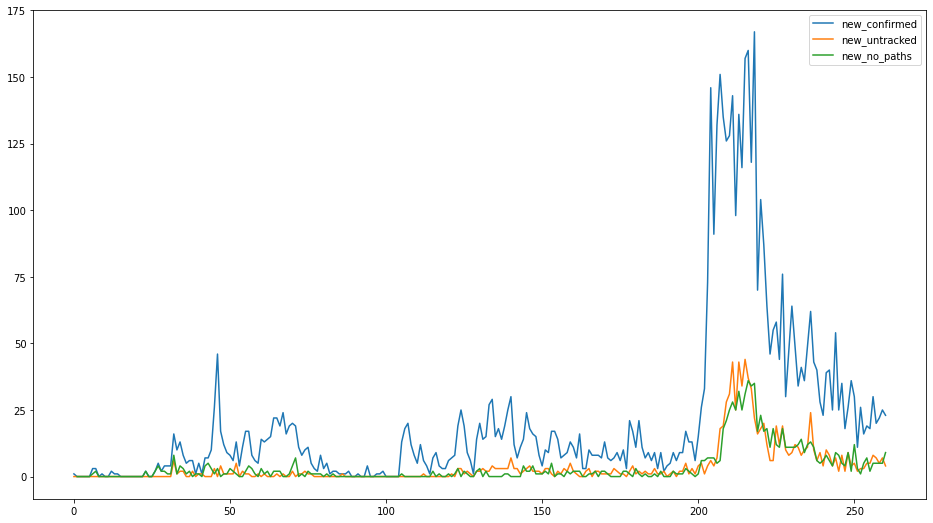

In [54]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

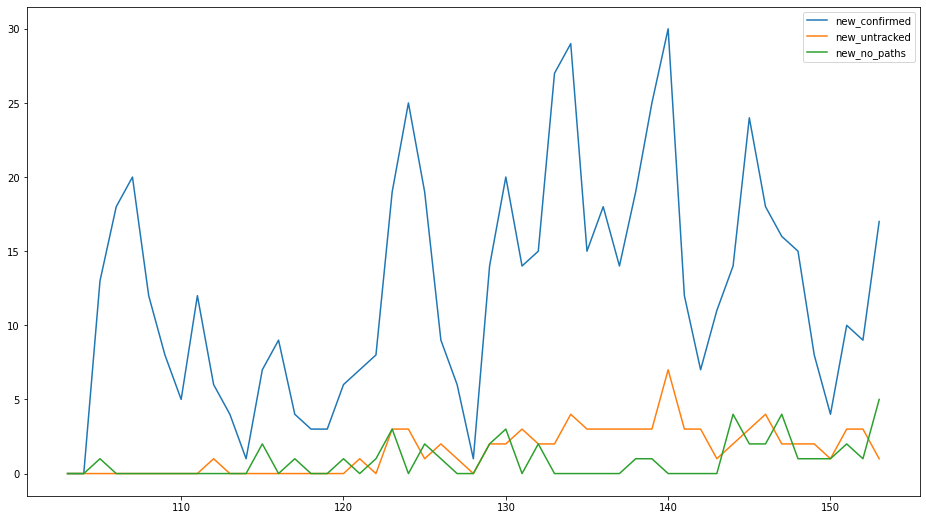

In [55]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


<AxesSubplot:>

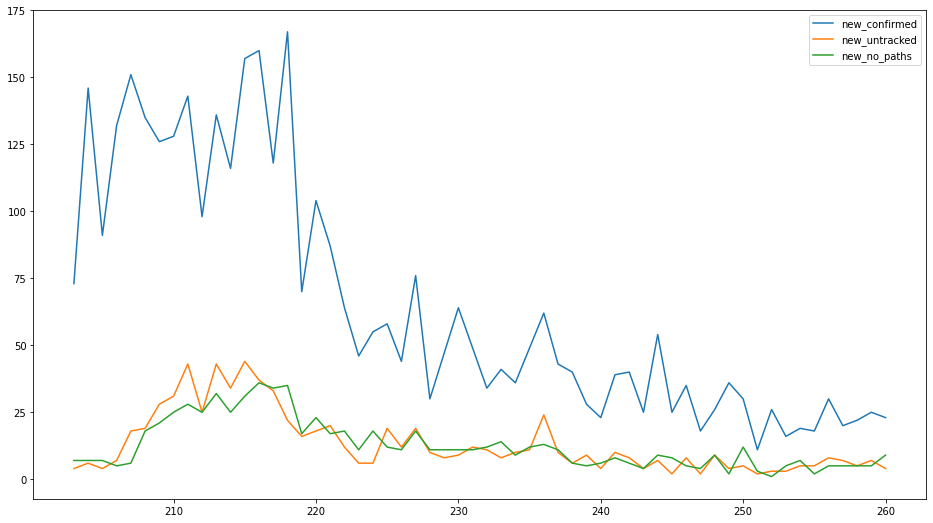

In [56]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14")]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

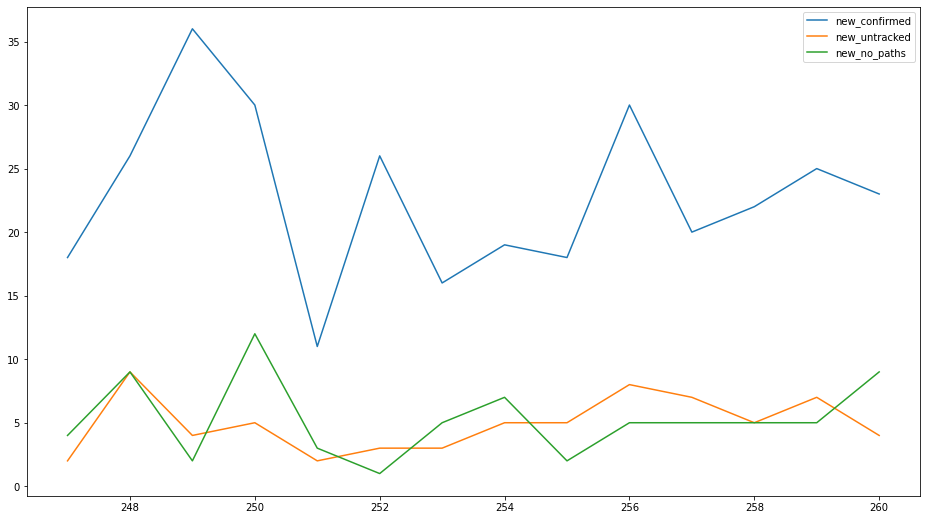

In [57]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

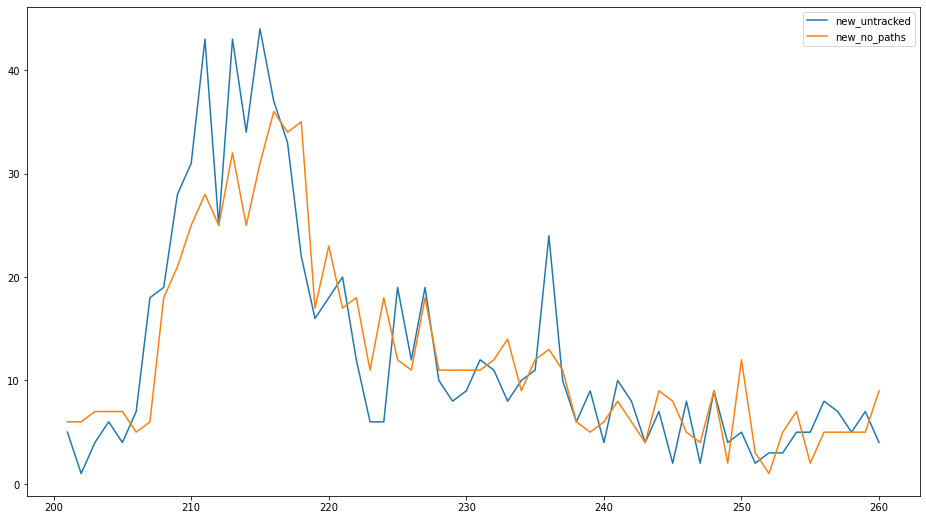

In [58]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
unknown_and_paths_graph = df_train[["new_untracked", "new_no_paths"]][-60:].plot(figsize=(16,9))
unknown_and_paths_graph

In [59]:
fig = unknown_and_paths_graph.get_figure()
fig.savefig('./img/unknown_and_paths_graph.png')